In [1]:
import pandas as pd
import numpy as np

In [2]:
def Monte_GBM(S,v,mu,n,T, nstep=5):
    dt = T/nstep
    e = np.random.normal(loc=0.0, scale=1.0, size=(n,nstep))
    S_T = S*np.exp((mu - v ** 2 / 2) * dt + v * np.sqrt(dt) * e).cumprod(axis=1)
    return [np.mean(S_T[:,i]) for i in range(nstep)]

In [3]:
import yfinance as yf
from tqdm import tqdm

def fetch_stock_price(stock_symbol, start_date, end_date):
    # 使用 yf.Ticker() 建立 Ticker 對象
    stock = yf.Ticker(stock_symbol)

    # 使用 history() 方法取得歷史價格資訊
    stock_data = stock.history(start=start_date, end=end_date)

    return stock_data

stock_symbol = '2330.TW'

# 起始日期和結束日期
end_date = '2024-12-31'

# 擷取股票價格資訊
df = fetch_stock_price(stock_symbol=stock_symbol, start_date='2012-01-02',end_date=end_date)


In [4]:
df['ret'] = df['Close'].pct_change()
df = df.dropna()

In [17]:
str(df.iloc[0:0+250+60][-60:].index[-1])

'2013-04-12 00:00:00+08:00'

In [31]:
Estimation_window = 250
step_forward = 60

total = 0
act = 0

date_li = []
res_li = []

for i in tqdm(range(len(df)-Estimation_window+1)):
# for i in range(5):
    total+=1
    df_estimation = df.iloc[i:i+Estimation_window]
    # drift = np.log(df_estimation['ret']).mean()
    # vol = np.log(df_estimation['ret']).std()

    drift = df_estimation['ret'].mean()
    vol = df_estimation['ret'].std()
    S_t = df_estimation['Close'][-1]

    df_test = df.iloc[i:i+Estimation_window+step_forward]
    S_tp1 = df_test['Close'][-step_forward:].mean()


    # pred dir
    pred = np.mean(Monte_GBM(S = S_t, v=vol, mu=drift, n=10000, T=1, nstep=step_forward))
    dir_num = pred - S_t
    dir_dummy = 1 if dir_num > 0 else -1

    # act dir
    dir_num_act = S_tp1 - S_t
    dir_dummy_act = 1 if dir_num_act > 0 else -1

    if dir_dummy-dir_dummy_act==0:
        act+=1
        date_li.append(df.iloc[i:i+Estimation_window+step_forward][-step_forward:].index[-1])
        res_li.append(1)

    if dir_dummy-dir_dummy_act!=0:
        date_li.append(df.iloc[i:i+Estimation_window+step_forward][-step_forward:].index[-1])
        res_li.append(-1)
    # print(f'pred : {pred}, dir : {dir_dummy}')
    # print(f'actual : {S_tp1}, dir : {dir_dummy_act}')
    # print('===================')
    # print()

  0%|          | 0/2704 [00:00<?, ?it/s]

100%|██████████| 2704/2704 [03:14<00:00, 13.92it/s]


In [33]:
df_res = pd.DataFrame({
    'd':date_li,
    'result':res_li}
)

In [69]:
df_res['year'] = df_res['d'].dt.year
df_res['m'] = df_res['d'].dt.month

In [59]:
df_res

,d,result,year
0,2013-04-12 00:00:00+08:00,1,2013
1,2013-04-15 00:00:00+08:00,1,2013
2,2013-04-16 00:00:00+08:00,1,2013
3,2013-04-17 00:00:00+08:00,1,2013
4,2013-04-18 00:00:00+08:00,1,2013
...,...,...,...
2699,2024-01-31 00:00:00+08:00,-1,2024
2700,2024-01-31 00:00:00+08:00,-1,2024
2701,2024-01-31 00:00:00+08:00,-1,2024
2702,2024-01-31 00:00:00+08:00,-1,2024


In [42]:
import matplotlib.pyplot as plt
# plt.scatter(df_res['year'], df_res['result'])

array([[<AxesSubplot:xlabel='d'>, <AxesSubplot:xlabel='d'>,
        <AxesSubplot:xlabel='d'>, <AxesSubplot:xlabel='d'>],
       [<AxesSubplot:xlabel='d'>, <AxesSubplot:xlabel='d'>,
        <AxesSubplot:xlabel='d'>, <AxesSubplot:xlabel='d'>],
       [<AxesSubplot:xlabel='d'>, <AxesSubplot:xlabel='d'>,
        <AxesSubplot:xlabel='d'>, <AxesSubplot:xlabel='d'>]], dtype=object)

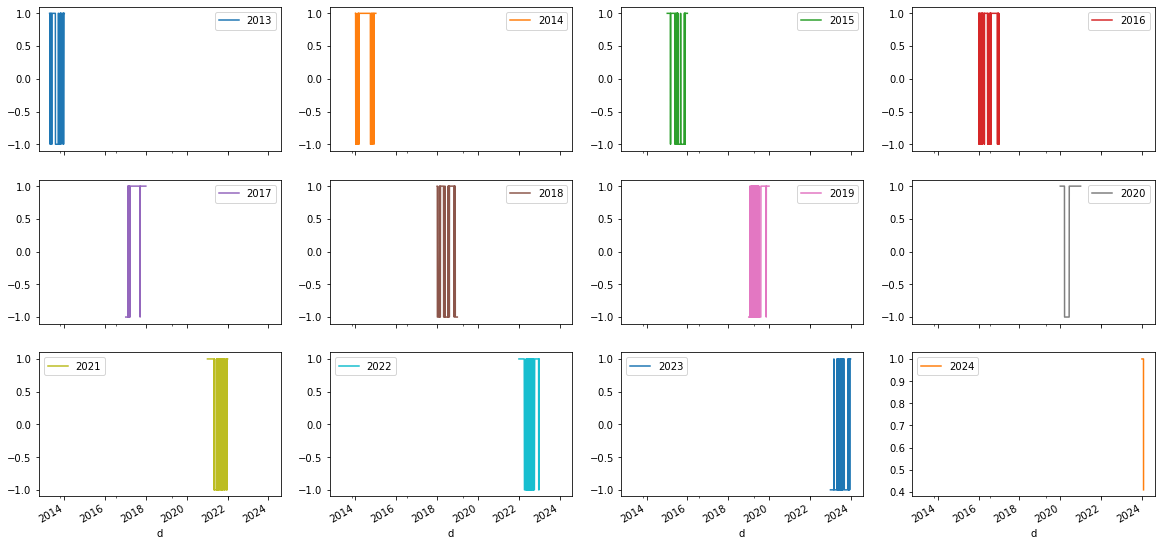

In [57]:
# pd.pivot_table(df_res.reset_index(),
#                index='d', columns='year', values='result'
#               ).plot(subplots=True, layout=(3,4), figsize=(20, 10))

In [24]:
# Estimation_window = 250
# step_forward = 60
# n=10000
print(act/total)

0.6642011834319527


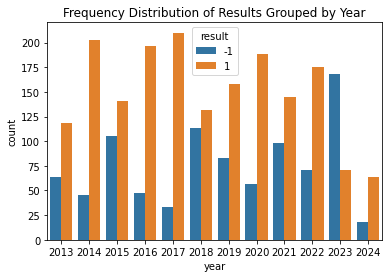

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
sns.countplot(x='year', hue='result', data=df_res)
plt.title('Frequency Distribution of Results Grouped by Year')
plt.show()


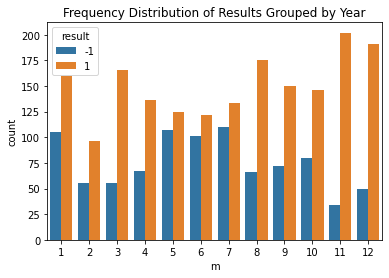

In [71]:
sns.countplot(x='m', hue='result', data=df_res)
plt.title('Frequency Distribution of Results Grouped by Year')
plt.show()
